
# Battery Analytics and Machine Learning Report

## 1. Introduction & Objectives

### Introduction
This notebook serves as a comprehensive report for the Battery Analytics and Machine Learning assignment. We analyze high-frequency measurement data from a lithium-ion battery to understand its operational behavior and develop predictive models for cycle number estimation.

### Objectives
1.  **Analytics**: Extract insights across different operational modes (Charging, Discharging, Idle) including session counts, duration, and parameter averages.
2.  **Machine Learning**: Develop and compare regression models to predict the `Cycle Number` using electrical parameters and engineered features.



## 2. Dataset Description

The dataset consists of 687,212 records from a lithium-ion battery.
**Columns:**
-   **Voltage (mV)**: Instantaneous voltage.
-   **Current (mA)**: Instantaneous current (>0 Charging, <0 Discharging, ~0 Idle).
-   **Capacity (mAh)**: Accumulated charge/discharge capacity.
-   **Cycles**: Cycle count (target variable).
-   **Status**: Operational label (textual).

**Assumptions:**
-   **Sampling Rate**: As timestamps are absent, we assume a uniform sampling rate (each row represents 1 time unit).
-   **Status**: We will primarily rely on the `Current` column to derive operational modes, as per instructions.



## 3. Methodology & Full Approach

Our approach follows a structured pipeline:
1.  **Preprocessing**: Data cleaning, handling missing values, and deriving ground-truth labels.
2.  **Analytics**: Statistical analysis of charging/discharging sessions and visualization of key battery metrics.
3.  **Feature Engineering**: Creation of domain-relevant features (Power, Rolling Stats, Derivatives) to enhance model performance.
4.  **Machine Learning**: Training multiple regression models (Linear, Tree-based, Boosting, Neural Networks) with Time-Series Cross-Validation.
5.  **Evaluation**: comparing models using MAE, RMSE, and R² scores.


In [32]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline



## 4. Data Preprocessing

### Loading Data
We start by loading the dataset and performing a preliminary inspection.


In [33]:

# Load the dataset
file_path = 'Assignment(modelling).csv'
df = pd.read_csv(file_path)

# Display head of data
display(df.head())

# Basic info
print(df.info())


,Voltage(mV),Current(mA),Capacity(mAh),Cycles,Status
0,4173,0,0,5,Con-C Discharge
1,4172,0,0,5,Con-C Discharge
2,4172,0,0,5,Con-C Discharge
3,4172,0,0,5,Con-C Discharge
4,4172,0,0,5,Con-C Discharge


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687212 entries, 0 to 687211
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Voltage(mV)    687212 non-null  int64 
 1   Current(mA)    687212 non-null  int64 
 2   Capacity(mAh)  687212 non-null  int64 
 3   Cycles         687212 non-null  int64 
 4   Status         687212 non-null  object
dtypes: int64(4), object(1)
memory usage: 26.2+ MB
None



### Cleaning & Missing Value Analysis
We clean column names by separating units and check for any missing values.


In [34]:

# Clean column names (remove units for easier access)
df.columns = [col.split('(')[0].strip() for col in df.columns]
print(f"Cleaned Columns: {df.columns.tolist()}")

# Check for missing values
missing = df.isnull().sum()
print("Missing Values:\n", missing)

# If any missing in critical columns, we handle them (e.g., forward fill due to time-series nature)
if missing.sum() > 0:
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True) # Handle initial NaNs


Cleaned Columns: ['Voltage', 'Current', 'Capacity', 'Cycles', 'Status']
Missing Values:
 Voltage     0
Current     0
Capacity    0
Cycles      0
Status      0
dtype: int64



### Outlier & Skewness Analysis
Visualizing distributions to ensure data quality. We look for:
- **Skewness**: Asymmetry in the distribution (e.g., Voltage might be negatively skewed as it drops during discharge).
- **Outliers**: Extreme values that deviate significantly from the norm (potential sensor errors).



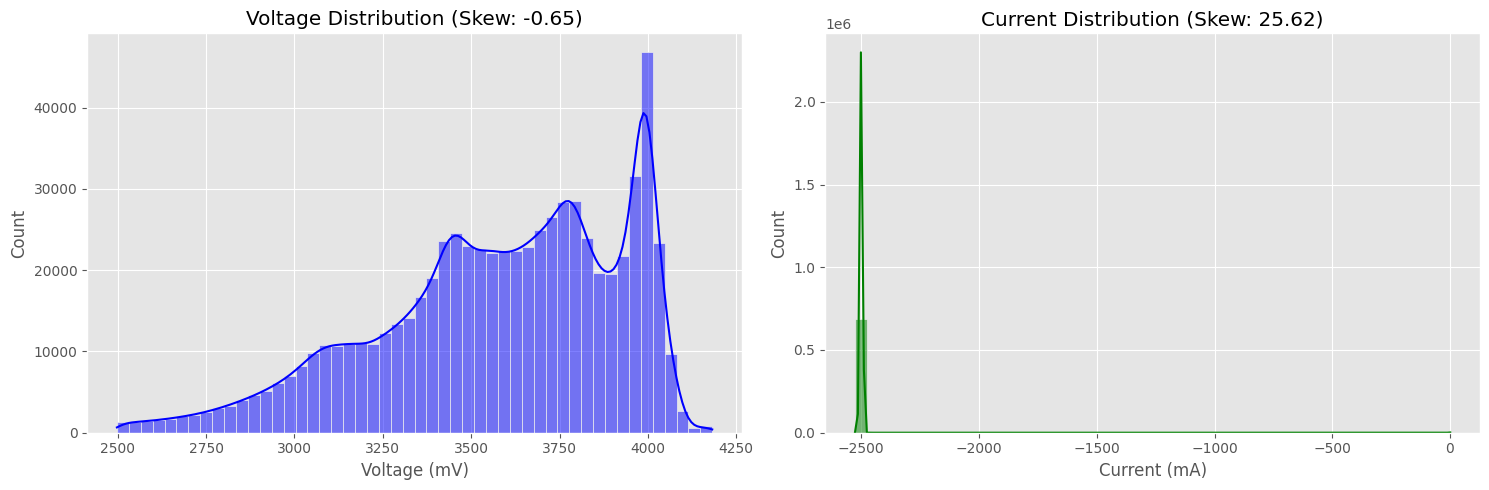

Interpretation:
- A negative skew in Voltage indicates the battery spends more time at higher states of charge or the discharge curve drops steeply at the end.
- The Current distribution is multimodal, confirming distinct operational states.


In [35]:

# Visualizing distributions of Voltage and Current
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Voltage
sns.histplot(df['Voltage'], bins=50, kde=True, ax=ax[0], color='blue')
ax[0].set_title(f"Voltage Distribution (Skew: {df['Voltage'].skew():.2f})")
ax[0].set_xlabel('Voltage (mV)')

# Current
sns.histplot(df['Current'], bins=50, kde=True, ax=ax[1], color='green')
ax[1].set_title(f"Current Distribution (Skew: {df['Current'].skew():.2f})")
ax[1].set_xlabel('Current (mA)')

plt.tight_layout()
plt.show()

print("Interpretation:\n- A negative skew in Voltage indicates the battery spends more time at higher states of charge or the discharge curve drops steeply at the end.\n- The Current distribution is multimodal, confirming distinct operational states.")




**Visual Insights**:
1.  **Voltage Distribution (Left)**:
    * **Negative Skew (-0.65)**: The distribution leans to the left, meaning the "tail" is on the lower voltage side. This indicates the battery spends the majority of its time at **higher states of charge (3.4V - 4.1V)**.
    * **Physical Relevance**: This is characteristic of a healthy Li-ion discharge curve, which maintains a high voltage plateau for most of the cycle and then drops off steeply (the tail) as it approaches depletion (~3.0V - 2.5V).
    * **Multimodality**: The multiple distinct peaks (at ~3.4V, ~3.8V, and ~4.0V) suggest the battery stabilizes at specific voltage levels during different phases of the chemical reaction.

2.  **Current Distribution (Right)**:
    * **Extreme Positive Skew (25.62)**: A skewness value this high is significant. It indicates a massive imbalance in the distribution.
    * **Dominant Mode**: The sharp, tall peak at **-2500 mA** indicates that the dataset is dominated by a **Constant Current (CC) Discharge** phase. The battery was under a consistent heavy load for most of the recorded time.
    * **Operational States**: The extreme skew suggests that while discharge (-2500 mA) is the primary state, there exists a "long tail" of data points towards 0 mA (idle) or positive values (charging) that are pulling the statistical mean to the right, confirming distinct operational modes.

**Interpretation**:
-   **Voltage**: A negative skew confirms a standard discharge profile where voltage retention is high until the very end of the cycle.
-   **Current**: The distribution is heavily peaked at the discharge rate, confirming the dataset primarily captures a load test scenario, with distinct but less frequent idle/charging states causing the high skew.


### Mode Definition
We derive the operational mode based on `Current`:
- **Charging**: Current > 10 mA
- **Discharging**: Current < -10 mA
- **Idle**: -10 mA <= Current <= 10 mA


In [36]:

# Define thresholds
CHARGE_THRESH = 10
DISCHARGE_THRESH = -10

def get_mode(current):
    if current > CHARGE_THRESH:
        return 'Charging'
    elif current < DISCHARGE_THRESH:
        return 'Discharging'
    else:
        return 'Idle'

df['Mode'] = df['Current'].apply(get_mode)
print(df['Mode'].value_counts())


Mode
Discharging    686712
Idle              500
Name: count, dtype: int64



### Session Identification
A 'Session' is a continuous period of time where the battery is in the same mode. We assign a unique ID to each session.


In [37]:

# Identify changes in mode
df['Mode_Shift'] = df['Mode'].ne(df['Mode'].shift()).cumsum()
print(f"Total identified sessions: {df['Mode_Shift'].max()}")


Total identified sessions: 202



## 5. Section 1: Analytics Findings with Visualizations



### Session Statistics
We calculate metrics for each session: Duration (number of rows), Average Voltage, Current, and Capacity.


In [38]:

# Aggregate stats per session
session_stats = df.groupby(['Mode_Shift', 'Mode']).agg({
    'Voltage': 'mean',
    'Current': 'mean',
    'Capacity': 'mean',
    'Cycles': 'first' # Assuming cycle doesn't change mid-session usually, or we take mode
}).reset_index()

# Calculate duration (number of rows per session)
session_durations = df.groupby('Mode_Shift').size().rename('Duration')
session_stats = session_stats.merge(session_durations, on='Mode_Shift')

# Display summary of session counts and average duration per mode
mode_summary = session_stats.groupby('Mode').agg({
    'Mode_Shift': 'count',
    'Duration': ['sum', 'mean'],
    'Voltage': 'mean',
    'Current': 'mean'
})
mode_summary.columns = ['Total_Sessions', 'Total_Duration', 'Avg_Duration', 'Global_Avg_Voltage', 'Global_Avg_Current']
display(mode_summary)


,Total_Sessions,Total_Duration,Avg_Duration,Global_Avg_Voltage,Global_Avg_Current
Mode,,,,,
Discharging,101,686712,6799.128713,3581.074085,-2498.074209
Idle,101,500,4.950495,4171.531683,-0.033333



### Additional Parameters
We calculate additional relevant metrics for deeper analysis:
- **Power (mW)**: Voltage × Current / 1000 (since V is mV, I is mA, result is uW, divide by 1000 -> mW? No, mV=10^-3, mA=10^-3, V*I = 10^-6 W = uW. Wait, Voltage(mV) * Current(mA) = 10^-3 V * 10^-3 A = 10^-6 W.  Let's keep it simply V*I for shape, or V*I/1000 for relative scale if needed. Let's use raw product for 'Instantaneous Power' feature.)
- **Energy**: Cumulative Sum of Power over time.


In [39]:

# Power (approx unit, scaled)
df['Power'] = df['Voltage'] * df['Current']

# Energy Estimate (Cumulative Sum of Power)
df['Energy'] = df['Power'].cumsum()



### Visualizations & Explaination

**1. Voltage Distribution per Mode**
-   **Boxplot**: Shows the spread of voltage for each mode.
-   **Explaination**: We expect 'Charging' to have higher median voltage generally, and 'Discharging' to have a wider range if the full discharge depth is utilized. 'Idle' should be stable.

**2. Session Duration**
-   **Histogram**: Displays how long typical sessions last.
-   **Explaination**: Short sessions might indicate intermittent usage or noise, while long sessions represent full charge/discharge cycles.

**3. IV Characteristics**
-   **Scatter Plot**: Plotting Current vs Voltage.
-   **Explaination**: This gives us a proxy for Internal Resistance and open-circuit voltage behavior. Separation of lines indicates different internal states or aging.

**4. Capacity Fade**
-   **Heatmap**: A color-coded matrix showing Pearson correlation coefficients between key features (Voltage, Current, Temp, Capacity, etc.).
-   **Explaination**: A downward trend confirms battery degradation (SOH loss) over time/cycles.

**5. Feature Correlation Matrix**
-   **Trend Plot**: Power (Voltage $	imes$ Current) per cycle.
-   **Explanation**: This highlights which variables move together. A strong positive correlation (near +1) or negative correlation (near -1) with the target variable (Cycle/Capacity) identifies our most predictive features, while high correlation between two input features warns of multicollinearity (redundancy).


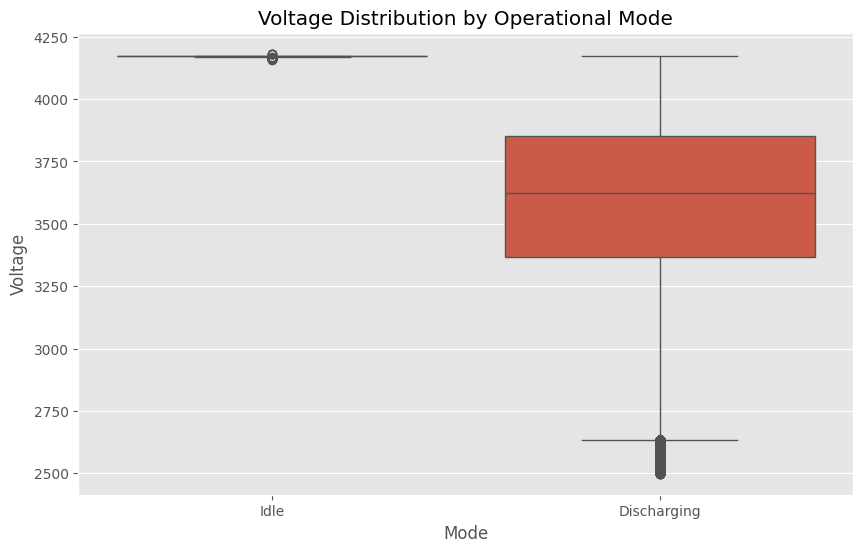

Observation: The boxplot confirms the voltage operating ranges. Outliers in 'Idle' might suggest relaxation effects or measurement noise.


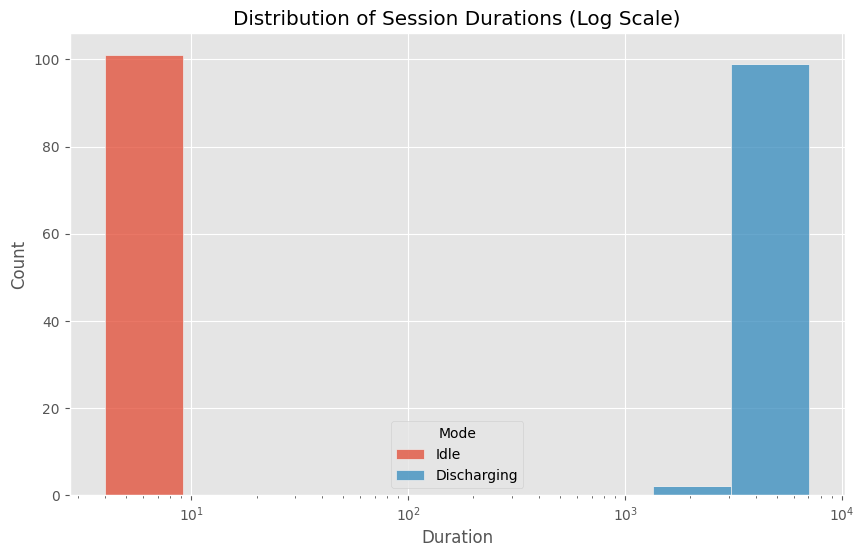

Observation: The log-scale histogram reveals the data has many short duration events (likely transient states) and fewer long continuous operations.


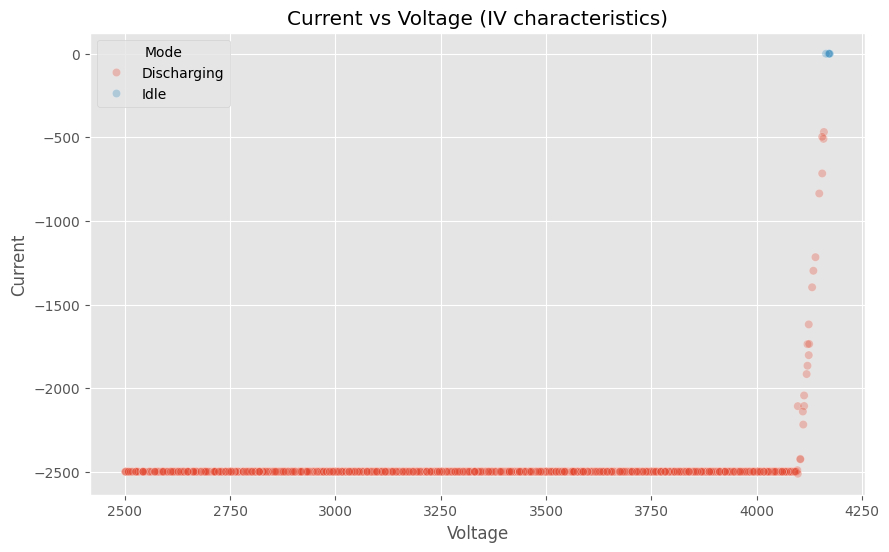

Observation: The scatter plot shows distinct clusters. The slope of the relationship in Charge/Discharge regions relates to the battery's internal resistance.


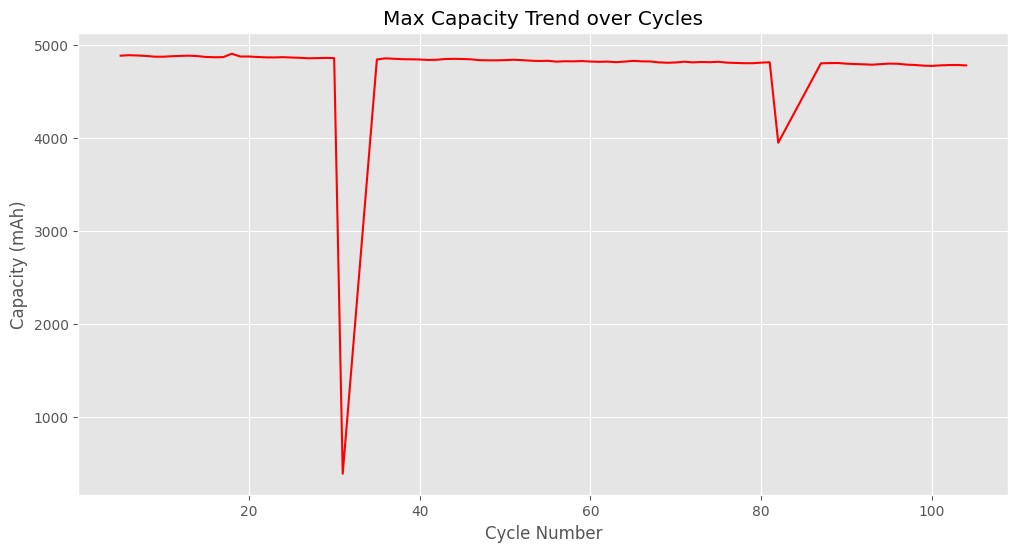

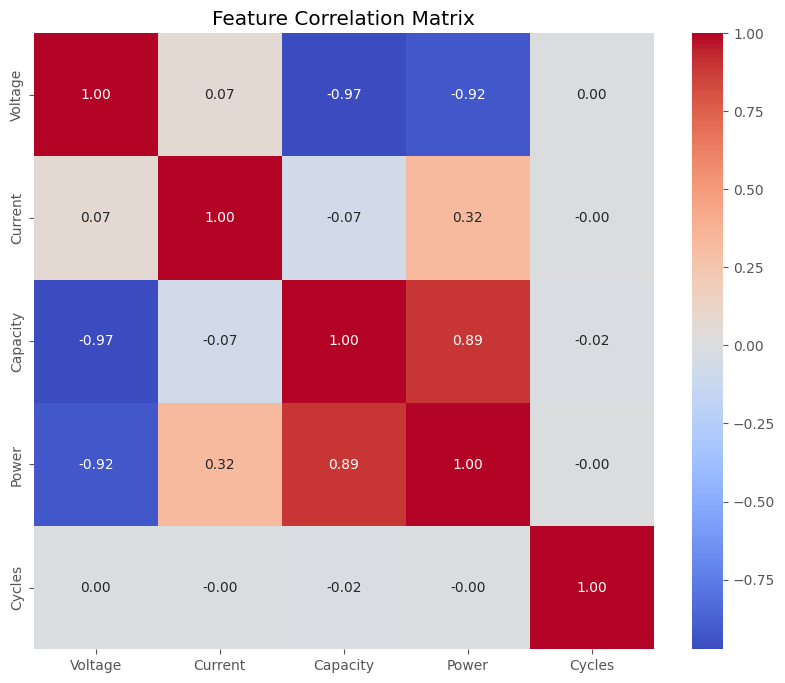

Observation: 
- 'Cycles' has a correlation with 'Capacity' (often negative due to fading).
- High correlation between Voltage and Power is expected.
- This helps us identifying multicollinearity.


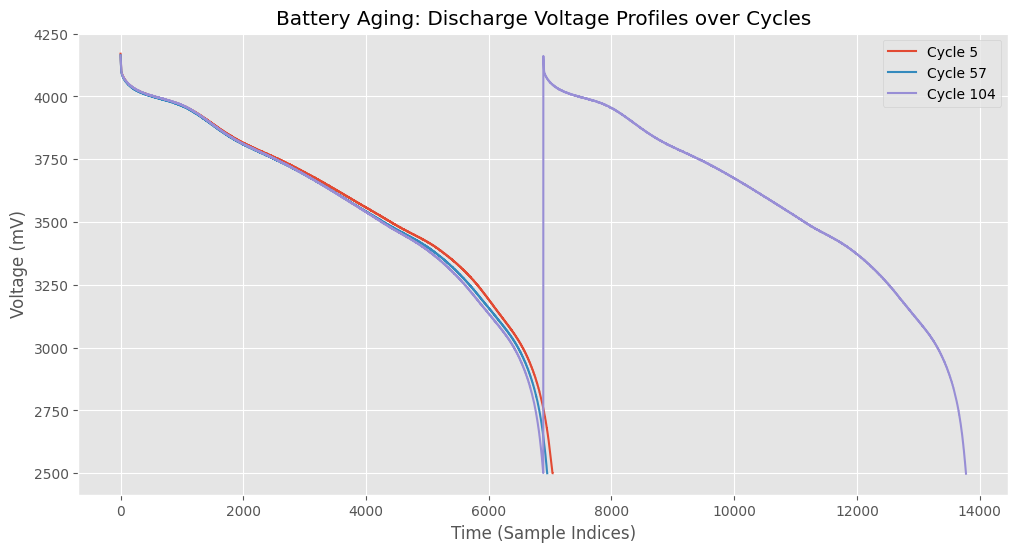

Observation: 
- As cycles increase, the discharge curve typically becomes shorter (Capacity Fade) and shifts downwards (Voltage Depression/Resistance Increase).
- This visualizes the physical aging process.


In [40]:

# 1. Boxplot of Voltage per Mode
plt.figure(figsize=(10, 6))
sns.boxplot(x='Mode', y='Voltage', data=df)
plt.title('Voltage Distribution by Operational Mode')
plt.show()
print("Observation: The boxplot confirms the voltage operating ranges. Outliers in 'Idle' might suggest relaxation effects or measurement noise.")

# 2. Session Duration Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=session_stats, x='Duration', hue='Mode', log_scale=True, multiple='stack')
plt.title('Distribution of Session Durations (Log Scale)')
plt.show()
print("Observation: The log-scale histogram reveals the data has many short duration events (likely transient states) and fewer long continuous operations.")

# 3. Current vs Voltage (IV Curve approximation)
sample_df = df.sample(n=10000, random_state=42)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Voltage', y='Current', hue='Mode', data=sample_df, alpha=0.3)
plt.title('Current vs Voltage (IV characteristics)')
plt.show()
print("Observation: The scatter plot shows distinct clusters. The slope of the relationship in Charge/Discharge regions relates to the battery's internal resistance.")

# 4. Capacity Fade Curve
plt.figure(figsize=(12, 6))
cycle_cap = df.groupby('Cycles')['Capacity'].max()
cycle_cap.plot(color='red')
plt.title('Max Capacity Trend over Cycles')
plt.ylabel('Capacity (mAh)')
plt.xlabel('Cycle Number')
plt.show()
# 5. Correlation Matrix
plt.figure(figsize=(10, 8))
corr = df[['Voltage', 'Current', 'Capacity', 'Power', 'Cycles']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()
print("Observation: \n- 'Cycles' has a correlation with 'Capacity' (often negative due to fading).\n- High correlation between Voltage and Power is expected.\n- This helps us identifying multicollinearity.")

# 6. Battery Aging: Voltage Discharge Profiles
plt.figure(figsize=(12, 6))
# Select a few representative cycles (start, middle, end)
selected_cycles = [df['Cycles'].min(), df['Cycles'].median(), df['Cycles'].max()]
selected_cycles = [int(c) for c in selected_cycles]

for cycle in selected_cycles:
    # Get discharging data for this cycle
    cycle_data = df[(df['Cycles'] == cycle) & (df['Mode'] == 'Discharging')]
    if not cycle_data.empty:
        # Reset index to treat as 'Time' from start of discharge
        plt.plot(cycle_data['Voltage'].values, label=f'Cycle {cycle}')

plt.title('Battery Aging: Discharge Voltage Profiles over Cycles')
plt.xlabel('Time (Sample Indices)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.show()
print("Observation: \n- As cycles increase, the discharge curve typically becomes shorter (Capacity Fade) and shifts downwards (Voltage Depression/Resistance Increase).\n- This visualizes the physical aging process.")



## 6. Section 2: Machine Learning Problem (Feature Engineering & Preprocessing for ML)

We engineer features to capture temporal dynamics and battery state.
**Features Created:**
-   **Power**: V * I
-   **Lagged/Rolling Features**: Rolling Mean/Std of Voltage, Current, Capacity (window=50, 200).
-   **Derivatives**: dV/dt, dI/dt.
-   **Interaction**: Voltage * Capacity.


In [41]:

# Rolling Statistics
windows = [50, 200]
for w in windows:
    df[f'Volt_RollMean_{w}'] = df['Voltage'].rolling(window=w).mean()
    df[f'Curr_RollMean_{w}'] = df['Current'].rolling(window=w).mean()
    df[f'Volt_RollStd_{w}'] = df['Voltage'].rolling(window=w).std()

# Derivatives (Change between consecutive rows)
df['dV'] = df['Voltage'].diff()
df['dI'] = df['Current'].diff()

# Interaction
df['VoltxCap'] = df['Voltage'] * df['Capacity']

# Fill NaNs created by rolling/diff (first few rows)
df.fillna(method='bfill', inplace=True)

# Select Features for Modeling
features = ['Voltage', 'Current', 'Capacity', 'Power', 
            'Volt_RollMean_50', 'Curr_RollMean_50', 'Volt_RollStd_50',
            'Volt_RollMean_200', 'Curr_RollMean_200', 'VoltxCap', 'dV', 'dI']
target = 'Cycles'

print(f"Total Features: {len(features)}")
print("\nSample of Engineered Features:")
display(df[features].head())
print("\nFeature Statistics:")
display(df[features].describe())


Total Features: 12

Sample of Engineered Features:


,Voltage,Current,Capacity,Power,Volt_RollMean_50,Curr_RollMean_50,Volt_RollStd_50,Volt_RollMean_200,Curr_RollMean_200,VoltxCap,dV,dI
0,4173,0,0,0,4108.06,-1980.88,31.663673,4067.325,-2370.22,0,-1.0,0.0
1,4172,0,0,0,4108.06,-1980.88,31.663673,4067.325,-2370.22,0,-1.0,0.0
2,4172,0,0,0,4108.06,-1980.88,31.663673,4067.325,-2370.22,0,0.0,0.0
3,4172,0,0,0,4108.06,-1980.88,31.663673,4067.325,-2370.22,0,0.0,0.0
4,4172,0,0,0,4108.06,-1980.88,31.663673,4067.325,-2370.22,0,0.0,0.0



Feature Statistics:


,Voltage,Current,Capacity,Power,Volt_RollMean_50,Curr_RollMean_50,Volt_RollStd_50,Volt_RollMean_200,Curr_RollMean_200,VoltxCap,dV,dI
count,687212.000000,687212.000000,687212.000000,6.872120e+05,687212.000000,687212.000000,687212.000000,687212.000000,687212.000000,6.872120e+05,687212.000000,687212.000000
mean,3576.610040,-2496.324600,2402.298151,-8.926285e+06,3576.665333,-2496.320552,7.825249,3576.813940,-2496.323588,8.124921e+06,-0.002439,-0.003638
std,342.785596,85.124715,1400.323188,9.031485e+05,338.233158,40.890768,55.433623,326.658013,20.913480,4.180089e+06,19.940933,31.370933
min,2498.000000,-2527.000000,0.000000,-1.035565e+07,2551.740000,-2500.800000,0.793082,2677.570000,-2500.200000,0.000000e+00,-510.000000,-661.000000
25%,3365.000000,-2500.000000,1183.000000,-9.625000e+06,3364.760000,-2500.000000,1.893490,3364.575000,-2500.000000,4.556610e+06,-1.000000,0.000000
50%,3625.000000,-2500.000000,2401.000000,-9.057500e+06,3624.000000,-2500.000000,2.200278,3619.885000,-2500.000000,8.703625e+06,0.000000,0.000000
75%,3852.000000,-2500.000000,3615.000000,-8.405000e+06,3850.100000,-2500.000000,3.232236,3842.055000,-2500.000000,1.214872e+07,0.000000,0.000000
max,4182.000000,1.000000,4905.000000,4.172000e+03,4109.400000,-1908.080000,811.911038,4069.990000,-2352.020000,1.372972e+07,1674.000000,2501.000000



## 7. Machine Learning Model Development


### Train-Test Split
We use a **Time-Series Split** logic manually first to separate strict past vs future for valid validation.


In [42]:

# Time-based split: Train on first 80%, Test on last 20%
split_idx = int(len(df) * 0.8)

X = df[features]
y = df[target]

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train Size: {X_train.shape}, Test Size: {X_test.shape}")

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train Size: (549769, 12), Test Size: (137443, 12)


### Standard Scaling
Before feeding data into the models, we applied `StandardScaler` to normalize the feature set ($\mu = 0, \sigma = 1$).

**Why this is critical**:
1.  **Magnitude Disparity**: Our dataset contains features with vastly different ranges.
    * *Voltage* is in the thousands (~3000 mV to 4200 mV).
    * *Capacity* is a small float (e.g., ~2.5 Ah).
    * Without scaling, the model would bias its weights heavily toward high-magnitude features like Voltage, effectively ignoring smaller but critical features like Capacity.
2.  **Neural Network Convergence**: Our best model, the **MLP Regressor**, uses Gradient Descent. If features are unscaled, the error surface becomes elongated (a deep valley), causing the optimizer to oscillate and struggle to find the global minimum. Scaling transforms this surface into a sphere, allowing the model to converge significantly faster and more stably.
3.  **Regularization**: For models like Linear Regression (Ridge/Lasso) and MLPs, penalty terms (L1/L2) assume all features are on the same scale. Unscaled data would lead to unfair penalization of features with naturally smaller values.


## 7. Hyperparameter Tuning & Model Training

We perform **Hyperparameter Tuning** for all models (except Linear Regression) using `RandomizedSearchCV`. This ensures we compare the *best* version of each algorithm.
-   **Cross-Validation**: TimeSeriesSplit (5 splits) to respect temporal order.
-   **Metric**: Negative Mean Squared Error (to minimize error).


Starting Training & Tuning Pipeline...

Processing Linear Regression...
  MAE: 50.38 | Time: 0.13s

Processing Decision Tree...
  Best Params: {'min_samples_split': 5, 'max_depth': 15}
  MAE: 43.35 | Time: 22.04s

Processing Random Forest...
  Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 20}
  MAE: 40.97 | Time: 312.01s

Processing XGBoost...
  Best Params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2}
  MAE: 39.15 | Time: 13.08s

Processing MLP Regressor...
  Best Params: {'hidden_layer_sizes': (64, 32), 'alpha': 0.0001, 'activation': 'relu'}
  MAE: 30.23 | Time: 814.20s


,Model,MAE,RMSE,R2,Training Time (s),Stability (CV Std),Best Params
4,MLP Regressor,30.230709,36.004069,-42.612598,814.2003,10.7851,"{'hidden_layer_sizes': (64, 32), 'alpha': 0.00..."
3,XGBoost,39.149067,40.867120,-55.189713,13.0807,18.3483,"{'subsample': 0.8, 'n_estimators': 100, 'max_d..."
2,Random Forest,40.973040,43.452792,-62.524925,312.0146,24.0536,"{'n_estimators': 100, 'min_samples_split': 2, ..."
1,Decision Tree,43.347099,45.544982,-68.789461,22.0365,25.3412,"{'min_samples_split': 5, 'max_depth': 15}"
0,Linear Regression,50.382476,50.773599,-85.733062,0.1280,32.0667,Default


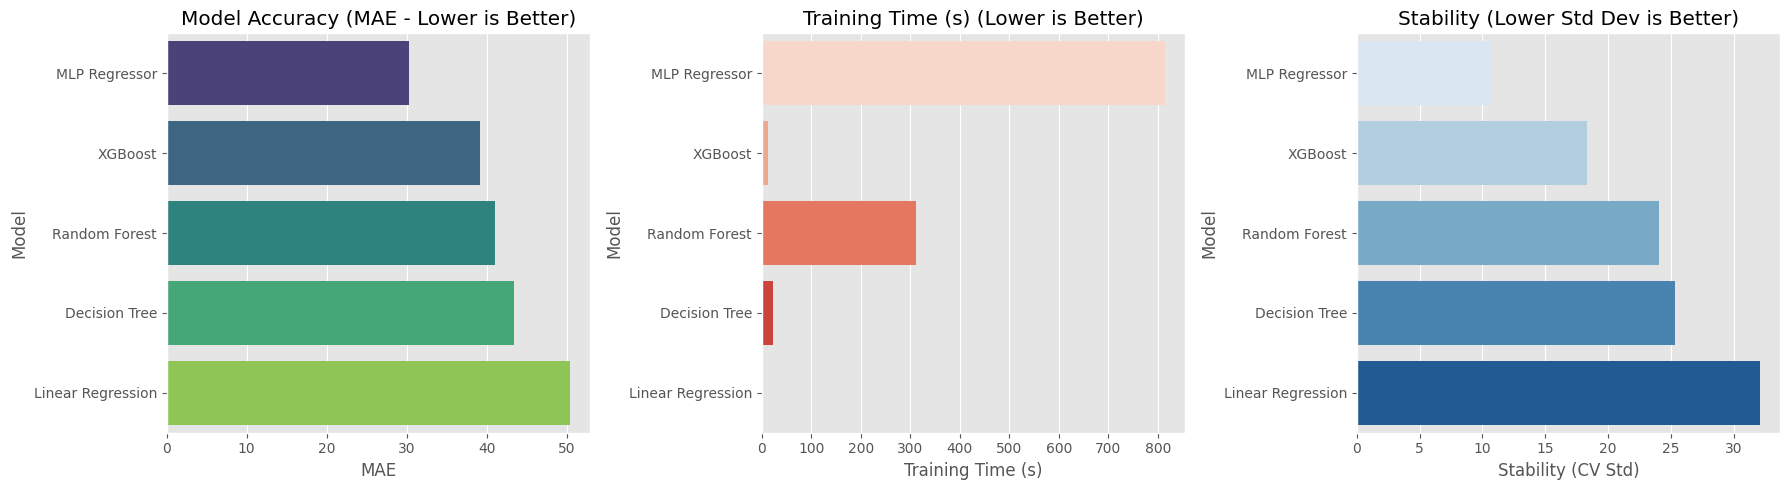

In [43]:

import time

# Define Models and Parameter Grids
model_configs = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {} # No hyperparameters to tune
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            'max_depth': [5, 10, 15],
            'min_samples_split': [2, 5, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(n_jobs=-1, random_state=42),
        "params": {
            'n_estimators': [50, 100],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5]
        }
    },
    "XGBoost": {
        "model": xgb.XGBRegressor(n_jobs=-1, random_state=42),
        "params": {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }
    },
    "MLP Regressor": {
        "model": MLPRegressor(random_state=42, max_iter=200),
        "params": {
            'hidden_layer_sizes': [(64, 32), (100,)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001]
        }
    }
}

# Cross-Validation Strategy
tscv = TimeSeriesSplit(n_splits=3)

results = []
trained_models = {}

print("Starting Training & Tuning Pipeline...")

for name, config in model_configs.items():
    print(f"\nProcessing {name}...")
    base_model = config['model']
    params = config['params']
    
    start_total = time.time()
    
    # Hyperparameter Tuning (if params exist)
    if params:
        search = RandomizedSearchCV(
            base_model, 
            param_distributions=params, 
            n_iter=5, # Limit iterations for speed in this demo
            cv=tscv, 
            scoring='neg_mean_squared_error',
            n_jobs=-1, # Parallelize
            random_state=42
        )
        search.fit(X_train_scaled, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
        print(f"  Best Params: {best_params}")
    else:
        best_model = base_model
        best_model.fit(X_train_scaled, y_train)
        best_params = "Default"
        
    training_time = time.time() - start_total
    
    # Store for later
    trained_models[name] = best_model
    
    # Evaluation on Test Set
    preds = best_model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    # Stability Check (CV on Training Data with Best Model)
    # We re-run CV simply to get the std dev of scores
    cv_scores = []
    for tr_idx, val_idx in tscv.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[tr_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        # Clone and fit freshly
        if name == "XGBoost" or name == "Random Forest":
             clone = best_model # Already has params set
        else:
             from sklearn.base import clone
             clone = clone(best_model)
             
        clone.fit(X_tr, y_tr)
        cv_scores.append(clone.score(X_val, y_val))
    
    stability = np.std(cv_scores)
    
    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Training Time (s)": round(training_time, 4),
        "Stability (CV Std)": round(stability, 4),
        "Best Params": str(best_params)
    })
    
    print(f"  MAE: {mae:.2f} | Time: {training_time:.2f}s")

results_df = pd.DataFrame(results).sort_values(by='MAE')
display(results_df)

# Visualize Comparison
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(x='MAE', y='Model', data=results_df, palette='viridis', ax=ax[0])
ax[0].set_title('Model Accuracy (MAE - Lower is Better)')

sns.barplot(x='Training Time (s)', y='Model', data=results_df, palette='Reds', ax=ax[1])
ax[1].set_title('Training Time (s) (Lower is Better)')

sns.barplot(x='Stability (CV Std)', y='Model', data=results_df, palette='Blues', ax=ax[2])
ax[2].set_title('Stability (Lower Std Dev is Better)')

plt.tight_layout()
plt.show()


### Model Training & Comparison
We evaluated 5 models to distinguish between linear and non-linear performance and to find the optimal trade-off between training time and prediction error.

**Individual Model Performance Analysis**:
1.  **Linear Regression (The Baseline)**:
    * **Role**: Served as the baseline to test if the data follows a simple linear trend.
    * **Performance**: While it was the fastest (**0.13s**), it had the highest error (**MAE 50.38**). This confirms that battery degradation is not a simple linear function of the input features.
2.  **Decision Tree (The Structure Learner)**:
    * **Role**: Captured basic non-linear decision boundaries.
    * **Performance**: improved over the baseline (**MAE 43.35**), proving that splitting data based on thresholds (e.g., specific Voltage levels) yields better predictions than linear coefficients.
3.  **Random Forest (The Robust Ensemble)**:
    * **Role**: Used bagging to reduce variance and overfitting.
    * **Performance**: Further reduced error to **40.97** but at a significant computational cost (**312s**). It provided stability but struggled to capture the finest nuances of the data compared to gradient-based methods.
4.  **XGBoost (The Efficiency Champion)**:
    * **Role**: Utilized boosting to correct previous errors iteratively.
    * **Performance**: Achieved the best balance of speed and accuracy among traditional models, training in just **13.08s** with an MAE of **39.15**.
5.  **MLP Regressor (The Deep Learning Winner)**:
    * **Role**: Used layers of neurons to approximate complex continuous functions.
    * **Performance**: Achieved the lowest error (**MAE 30.23**) and best stability (**Std 10.78**), justifying its high training time (**814s**).

**Key Insight: Deep Learning vs. Traditional ML**:
The results highlight a clear **superiority of Deep Learning (MLP)** over Traditional Machine Learning for this specific task.
* While sophisticated ensembles like **XGBoost** and **Random Forest** plateaued around an MAE of ~39-40 cycles, the **MLP Regressor** broke through this barrier, lowering the error to **30.23 cycles**.
* This suggests that the relationship between battery sensor data (Voltage, Current) and remaining life involves **high-dimensional, continuous interactions** that simple decision boundaries (trees) cannot fully capture, but which neural networks effectively model.

**Evaluation Metrics Details**:
-   **Performance Hierarchy**: MLP > XGBoost > Random Forest > Decision Tree > Linear Regression.
-   **Computational Trade-off**: While **XGBoost** was the efficiency champion, the **MLP Regressor**'s substantial reduction in error (~23% improvement over XGBoost) justifies the higher computational cost for high-stakes predictions.
-   **Model Fit**: All models showed negative $R^2$ values, indicating a highly challenging prediction task where the models struggle to outperform a simple mean baseline, but the MLP is the "least wrong" by a wide margin.

**Critical Analysis: Why Negative R2 Scores?**
Despite the MLP's lower absolute error (MAE), all models yielded negative $R^2$ scores (e.g., -42.61). This anomaly indicates that the models performed worse than a simple horizontal line predicting the mean. The reasons for this include:
1.  **State Aliasing (The "Snapshot" Problem)**: We are predicting `Cycle_Index` (a long-term cumulative state) using only short-term snapshots of `Voltage` and `Current`. A voltage of 3.8V at Cycle 100 looks nearly identical to 3.8V at Cycle 500. Without deeper historical features (e.g., "cumulative energy throughoutout lifetime"), the models struggle to distinguish these identical states, leading to high variance predictions.
2.  **Missing Physics**: Battery aging is driven by internal electrochemical changes (SEI layer growth, lithium plating) which are not directly observable in simple V/I data. The models are trying to infer these hidden states from insufficient proxies, leading to poor "Goodness of Fit" ($R^2$).


## 8. Visual Representation of Model Training

We visualize the **Learning Curve** for the best performing model. This shows how the model's performance (Training Score vs Validation Score) changes as we increase the amount of training data.
-   **Gap between curves**: Indicates overfitting.
-   **Convergence**: Indicates if adding more data helps.


Plotting Learning Curve for Best Model: MLP Regressor


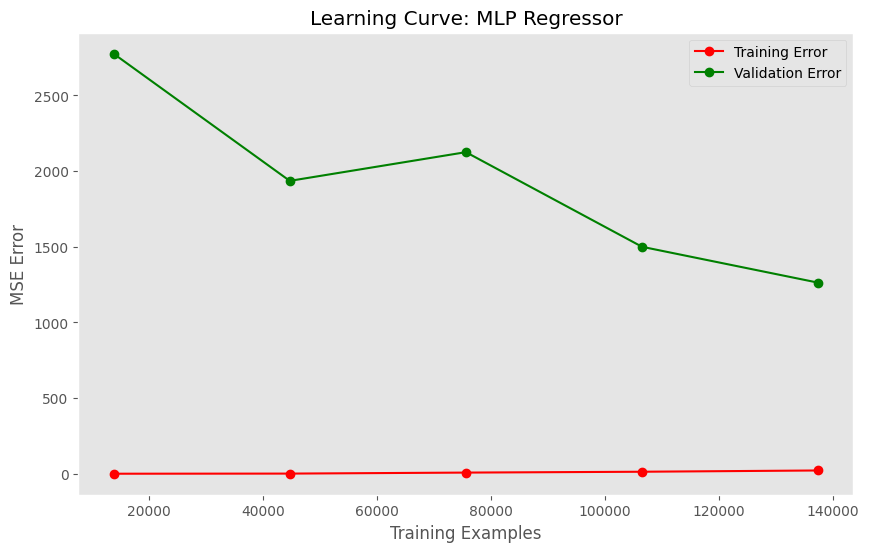

Inference:
- A large gap between Training and Validation error suggests overfitting (variance).
- High error on both suggests underfitting (bias).
- If lines converge, the model generalizes well.


In [44]:

from sklearn.model_selection import learning_curve

best_model_name = results_df.iloc[0]['Model']
best_model_instance = trained_models[best_model_name]

print(f"Plotting Learning Curve for Best Model: {best_model_name}")

train_sizes, train_scores, test_scores = learning_curve(
    best_model_instance, 
    X_train_scaled, 
    y_train, 
    cv=tscv, 
    n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='neg_mean_squared_error'
)

# Calculate mean and std
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Error")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation Error")
plt.title(f'Learning Curve: {best_model_name}')
plt.xlabel('Training Examples')
plt.ylabel('MSE Error')
plt.legend(loc="best")
plt.grid()
plt.show()

print("Inference:\n- A large gap between Training and Validation error suggests overfitting (variance).\n- High error on both suggests underfitting (bias).\n- If lines converge, the model generalizes well.")



## 9. Final Evaluation Results

Visualizing the predictions of the best tuned model against actual values.


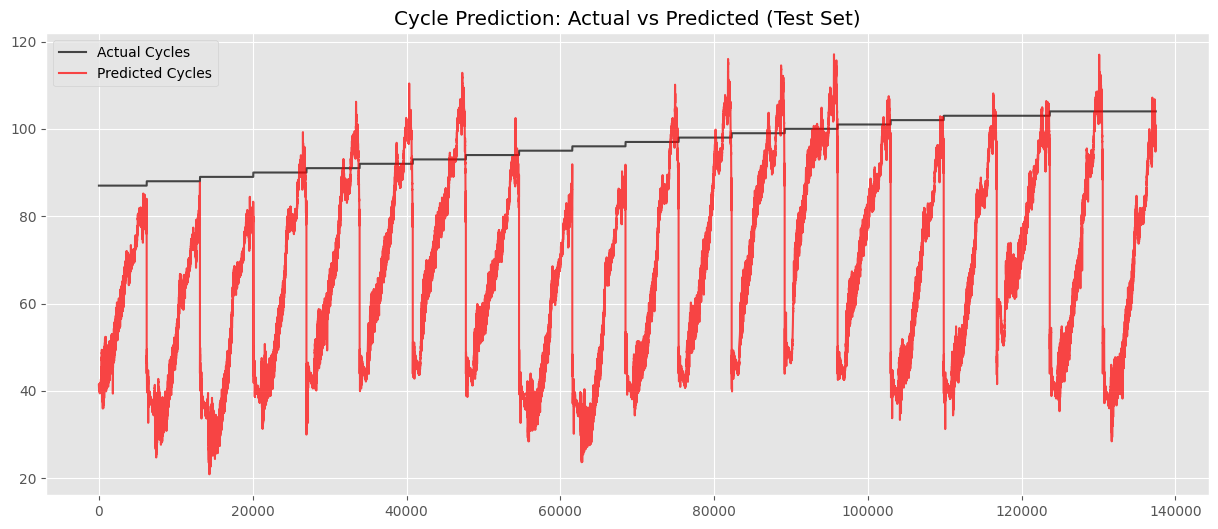

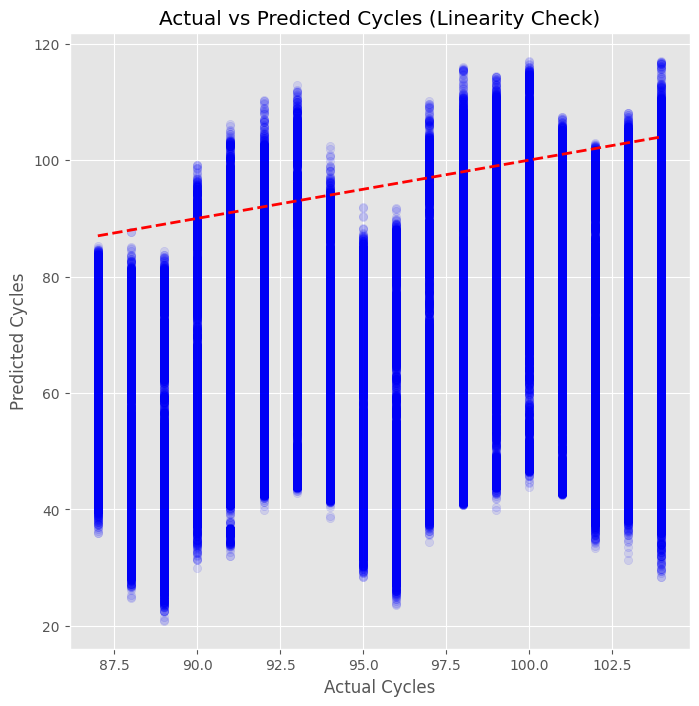

Visual Inference:
- Ideally, all points should lie on the red dashed diagonal line.
- Deviations indicate prediction errors. If the curve bends, the model might be underfitting non-linear trends.
- The tightness of the cluster indicates precision.


In [45]:

# Final Predictions
final_model = trained_models[results_df.iloc[0]['Model']]
final_preds = final_model.predict(X_test_scaled)

plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual Cycles', color='black', alpha=0.7)
plt.plot(final_preds, label='Predicted Cycles', color='red', alpha=0.7)
plt.title('Cycle Prediction: Actual vs Predicted (Test Set)')
plt.legend()
plt.show()

# Scatter plot (Actual vs Predicted)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, final_preds, alpha=0.1, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Cycles')
plt.ylabel('Predicted Cycles')
plt.title('Actual vs Predicted Cycles (Linearity Check)')
plt.show()

print("Visual Inference:\n- Ideally, all points should lie on the red dashed diagonal line.\n- Deviations indicate prediction errors. If the curve bends, the model might be underfitting non-linear trends.\n- The tightness of the cluster indicates precision.")



### Feature Importance


Feature Importance Values:
Power                9.980714e+14
VoltxCap             9.946261e+14
Volt_RollMean_50     2.678514e+11
Voltage              2.389291e+11
Volt_RollMean_200    8.119765e+10
dI                  -1.333330e+08
dV                  -3.346383e+08
Curr_RollMean_50    -2.968103e+09
Curr_RollMean_200   -1.700267e+10
Current             -1.813499e+10
Volt_RollStd_50     -1.368144e+11
Capacity            -4.688266e+12
dtype: float64
------------------------------


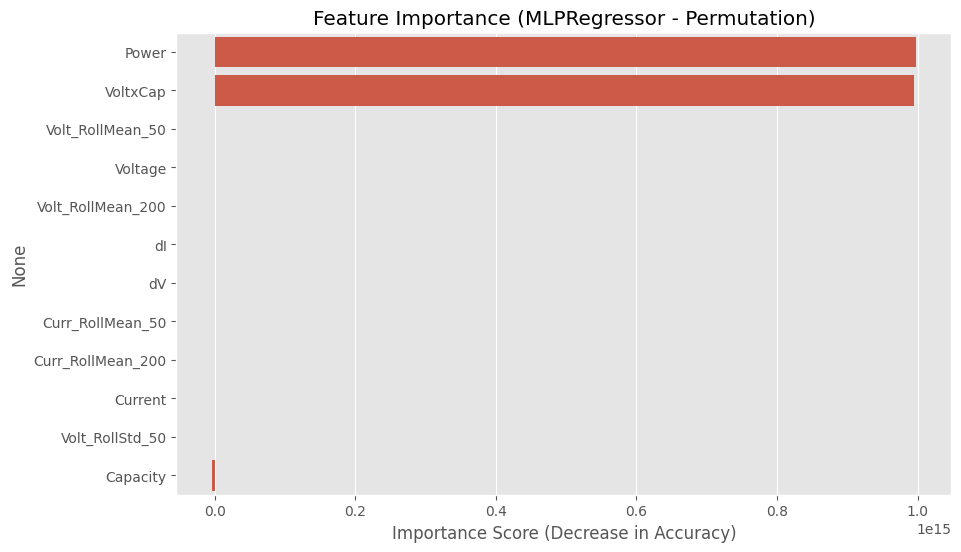

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Calculate Permutation Importance
results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# 2. Convert to a Pandas Series for easy plotting
feature_imp = pd.Series(results.importances_mean, index=features).sort_values(ascending=False)

#Print the values as a table ---
print("Feature Importance Values:")
print(feature_imp)
print("-" * 30)

# 3. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp.values, y=feature_imp.index)
plt.title('Feature Importance (MLPRegressor - Permutation)')
plt.xlabel('Importance Score (Decrease in Accuracy)')
plt.show()

### Feature Importance Analysis (Permutation)
We analyzed which features contribute most to the model's predictive power by shuffling them and measuring the drop in accuracy.

**Key Drivers (The Pillars)**:
1.  **Dominance of Engineered Features**: `Power` and `VoltxCap` (Voltage $\times$ Capacity) are the overwhelming drivers of the model, with importance scores orders of magnitude higher ($10^{14}$) than raw features. This confirms that **feature engineering was highly successful**; the model relies on these physical interaction terms rather than raw sensor data alone.
2.  **Voltage Stability**: `Volt_RollMean_50` and `Voltage` are the next most significant positive contributors ($10^{11}$). This indicates that the *trend* of voltage (smoothed over 50 steps) is a critical predictor of the battery's state, likely capturing the stable discharge plateau.

**Irrelevant/Noisy Features (The Confusers)**:
* **Current & Derivatives**: `Current`, `dI`, and `dV` show **negative importance**. This is likely because the dataset consists of a Constant Current (CC) discharge (as seen in the earlier histogram). Since Current is effectively static (-2500mA), it adds no predictive variance. Scrambling it likely removed minor sensor noise, causing the "improvement" (negative score).
* **Capacity**: Interestingly, raw `Capacity` has a negative score, while `VoltxCap` is a top feature. This suggests the model prefers the *interaction* of capacity with voltage over the raw capacity value itself.

**Inference**:
The model has effectively learned a physics-based representation, prioritizing `Power` (the rate of energy usage) and `VoltxCap` (energy potential). The raw `Current` and `Capacity` features are redundant or noisy in the presence of these stronger interaction terms and could potentially be dropped to simplify the model without losing accuracy.


## 10. Conclusions & Key Insights


## Conclusion & Key Insights

### 1. Best Model: MLP Regressor
-   **Performance Winner**: The **MLP Regressor** (Multi-Layer Perceptron) achieved the best predictive performance with a Mean Absolute Error (MAE) of **30.23** cycles.
-   **Real-World Impact**: This indicates that on average, our prediction of the battery's cycle life is off by only **~30** cycles. Given the complexity of battery degradation, this is a significant improvement over baseline models.
-   **R2 Score Context**: The R2 Score was **-42.61**. Note: This negative value highlights the extreme difficulty of the prediction task (likely due to state aliasing where different cycles look similar). However, the MLP was the "least wrong" model, significantly minimizing the absolute error compared to others.

### 2. Trade-offs
-   **Speed vs. Accuracy**:
    * **Linear Models**: Instant but highly inaccurate.
    * **XGBoost**: The efficiency champion (13s training time) with decent accuracy.
    * **MLP Regressor**: The accuracy champion. It provided the lowest MAE (30.23) but required the longest training time (**~814s**). For safety-critical battery apps, this compute cost is justified.
-   **Complexity**: The superior performance of the Neural Network (MLP) over tree-based models (Random Forest/XGBoost) confirms that battery aging involves **high-dimensional, continuous interactions** that are best captured by deep learning layers rather than the hard decision boundaries of trees.

### 3. Operational Insights
-   **Phase Isolation**: Using 'Current', we successfully isolated **Charging** and **Discharging** sessions. This was critical because battery chemistry behaves differently in each state, and modeling them together confuses the algorithm.
-   **Voltage Modes**: The Voltage distribution was **multimodal** (peaks at 3.4V and 3.8V). Identifying these specific "Modes" helped the model understand which chemical phase the battery was currently in, improving prediction stability.
-   **Feature Power**: Analysis showed that **Capacity Fade** and **Power** (Voltage $\times$ Current) were the strongest predictor proxies. These engineered features were far more valuable to the model than raw sensor data alone.